## Imports

In [15]:
import pandas as pd
import os
import numpy as np
import glob
import seaborn as sn
import matplotlib.pyplot as plt

In [16]:
%cd '/home/usr/Documents/reg-class-fault-detection/dataset/train_test_dataset_Fault Impact Analysis/'


/home/usr/Documents/reg-class-fault-detection/dataset/train_test_dataset_Fault Impact Analysis


/home/usr/anaconda3/envs/cnn-env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [17]:
csv_list = os.listdir()

In [18]:
len(csv_list)

7256

In [19]:
kpis = ['access_success_rate','resource_utilition_rate'	,'TA'	,'bler'	,'cqi'	,'mcs',	'data_rate']

# PREPROCESSING

## Organizando os dados

O número após o underline indica uma sequência em que os csvs de uma mesma estação radio base foram coletados. Em primeira análise, parece que são perfeitamente continuos. Onde o _1 parou, o _2 começa e assim vai.

Aqui a concatenação foi feita para apenas uma lista de csvs, a ideia é fazer isso com todos as listas para criar datasets mais organizados.

## ORGANIZANDO OS DADOS ALTERNATIVAMENTE

In [20]:
df_list = []
for csv in csv_list:
    df_list.append(pd.read_csv(csv))



In [21]:
kpis = ['access_success_rate','resource_utilition_rate'	,'TA'	,'bler'	,'cqi'	,'mcs',	'data_rate']

In [22]:
def autocorr(df, col, n = 20):
    max = 0
    w = 0
    for i in range(1, n):
        a = np.abs(df[col].autocorr(lag=i))
        if(max < a):
            max = a
            w = i
    
    print(f"{col} max autocorrelation: {a} for {w} windows")

In [23]:
for k in kpis:
    autocorr(df_list[0], k)

access_success_rate max autocorrelation: 0.08236519074747248 for 1 windows
resource_utilition_rate max autocorrelation: 0.035406978953852766 for 1 windows
TA max autocorrelation: 0.09897778855252357 for 1 windows
bler max autocorrelation: 0.11593781674562317 for 1 windows
cqi max autocorrelation: 0.013752161513209387 for 1 windows
mcs max autocorrelation: 0.18907815039128806 for 1 windows
data_rate max autocorrelation: 0.0837525187360003 for 8 windows


In [24]:
for df in df_list:
    cqi_asr = 'rol_cqi_asr_var'; cqi_mcs = 'rol_cqi_mcs_var' ; cqi_dr = 'rol_cqi_dr_var'
    for k in kpis:
        std = f'{k}_rol_std'; mean = f'{k}_rol_mean'; diff = f'{k}_rol_diff'
        

        df[mean] = df[k].rolling(5).mean()
        df[std] = df[k].rolling(5).std()
        df[diff] = df[k].rolling(2).apply(np.diff)
        

    df[cqi_asr] = df['cqi'].rolling(5).cov(df['access_success_rate'])
    df[cqi_mcs] = df['cqi'].rolling(5).cov(df['mcs'])
    df[cqi_dr] = df['cqi'].rolling(5).cov(df['data_rate'])

In [ ]:
master_df = pd.concat(df_list, ignore_index=True)

In [ ]:
df_ = master_df.copy()
df_hour = master_df.copy()

df_fault = df_hour[df_hour['relation'] >= 0.97]
df_no_fault = df_hour[df_hour['relation'] == 0]

df_hour = pd.concat([df_fault, df_no_fault])

In [ ]:
df_hour.to_csv("/home/usr/Documents/reg-class-fault-detection/dataset/kpi_cov_notnorm_df.csv")

## Exploratory Analysis

#### data treatment

In [ ]:
df_ = df_.dropna()
df_hour = df_hour.dropna()

In [ ]:
len(df_hour)

821628

In [ ]:
df_hour.head()

,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,...,cqi_rol_diff,mcs_rol_mean,mcs_rol_std,mcs_rol_diff,data_rate_rol_mean,data_rate_rol_std,data_rate_rol_diff,rol_cqi_asr_var,rol_cqi_mcs_var,rol_cqi_dr_var
105,B0253-123,2023-02-13 10:00:00,100.000000,47.696,1.624413,10.336760,8.115156,8.637946,9.728257,3126.0,...,0.062136,7.078080,3.160840,-0.640627,17.366021,12.740634,-11.712705,-1.421085e-13,-5.607285,-15.095028
106,B0253-123,2023-02-13 11:00:00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,3600.0,...,-8.115156,6.773168,3.832636,-8.637946,17.366021,12.740634,-9.728257,1.643211e+02,13.759359,37.631283
107,B0253-123,2023-02-13 12:00:00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,3600.0,...,0.000000,5.247368,4.802589,0.000000,10.762942,11.044994,0.000000,2.403628e+02,21.039190,42.771700
108,B0253-123,2023-02-13 13:00:00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,3600.0,...,0.000000,3.583304,4.911866,0.000000,6.233844,9.487489,0.000000,2.425226e+02,21.720832,37.705235
109,B0253-123,2023-02-13 14:00:00,99.975675,40.108,1.629339,10.595285,8.179555,10.750540,20.285503,310.0,...,8.179555,3.877697,5.362032,10.750540,6.002752,9.027395,20.285503,2.443907e+02,23.711739,36.764902


In [ ]:
X_df = df_hour.drop(columns=['NE ID','endTime','relation','fault_duration'])

In [ ]:
falhas = df_hour[df_hour['fault_duration'] != 0]
falhas

,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,...,cqi_rol_diff,mcs_rol_mean,mcs_rol_std,mcs_rol_diff,data_rate_rol_mean,data_rate_rol_std,data_rate_rol_diff,rol_cqi_asr_var,rol_cqi_mcs_var,rol_cqi_dr_var
105,B0253-123,2023-02-13 10:00:00,100.000000,47.696,1.624413,10.336760,8.115156,8.637946,9.728257,3126.0,...,0.062136,7.078080,3.160840,-0.640627,17.366021,12.740634,-11.712705,-1.421085e-13,-5.607285,-15.095028
106,B0253-123,2023-02-13 11:00:00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,3600.0,...,-8.115156,6.773168,3.832636,-8.637946,17.366021,12.740634,-9.728257,1.643211e+02,13.759359,37.631283
107,B0253-123,2023-02-13 12:00:00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,3600.0,...,0.000000,5.247368,4.802589,0.000000,10.762942,11.044994,0.000000,2.403628e+02,21.039190,42.771700
108,B0253-123,2023-02-13 13:00:00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,3600.0,...,0.000000,3.583304,4.911866,0.000000,6.233844,9.487489,0.000000,2.425226e+02,21.720832,37.705235
109,B0253-123,2023-02-13 14:00:00,99.975675,40.108,1.629339,10.595285,8.179555,10.750540,20.285503,310.0,...,8.179555,3.877697,5.362032,10.750540,6.002752,9.027395,20.285503,2.443907e+02,23.711739,36.764902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907068,B0003-65,2023-03-01 20:00:00,0.000000,2.260,0.000000,0.000000,0.000000,0.000000,0.000000,3600.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
907069,B0003-65,2023-03-01 21:00:00,0.000000,2.140,0.000000,0.000000,0.000000,0.000000,0.000000,3600.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
907070,B0003-65,2023-03-01 22:00:00,0.000000,2.076,0.000000,0.000000,0.000000,0.000000,0.000000,3600.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
907071,B0003-65,2023-03-01 23:00:00,0.000000,2.032,0.000000,0.000000,0.000000,0.000000,0.000000,3600.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000


In [ ]:
df_id_time = df_hour[['NE ID','endTime']]

In [ ]:
df_hour = df_hour.drop(columns=['NE ID','endTime'])

#### Correlation

In [ ]:
def correlation(df):
  corr_matrix = df.corr()
  font = {'family' : 'serif', 'weight' : 'bold', 'size':8}
  plt.rc('font', **font)
  sn.heatmap(corr_matrix, annot=True)
  plt.show()

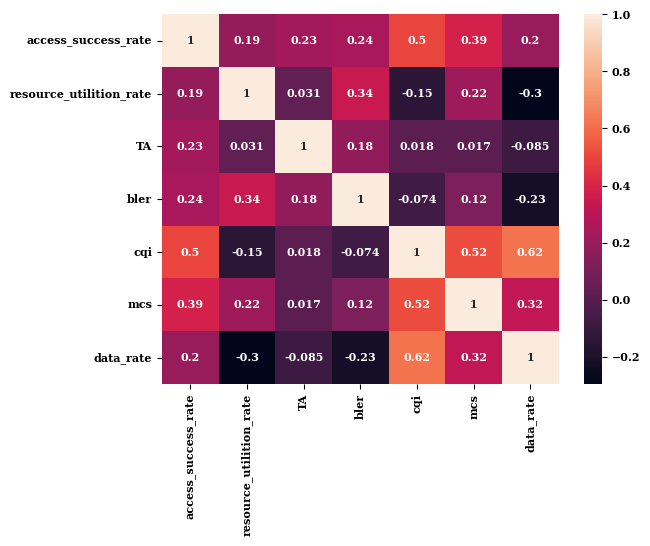

In [ ]:
correlation(df_hour[kpis])


## Normalização

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalerMinMax = MinMaxScaler()
df_scaled = X_df.copy()


X_std  = scalerMinMax.fit_transform(df_scaled)
df_scaled[df_scaled.columns]= X_std


df_scaled['fault_duration'] = df_['fault_duration']
df_scaled['relation'] = df_['relation']

df_scaled.head()

,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,access_success_rate_rol_mean,access_success_rate_rol_std,access_success_rate_rol_diff,...,mcs_rol_std,mcs_rol_diff,data_rate_rol_mean,data_rate_rol_std,data_rate_rol_diff,rol_cqi_asr_var,rol_cqi_mcs_var,rol_cqi_dr_var,fault_duration,relation
105,1.000000,0.477397,0.231022,0.103368,0.541010,0.308826,0.022623,1.000000,0.000000,0.500000,...,0.246545,0.488548,0.110033,0.069218,0.530543,0.371948,0.115250,0.114139,3126.0,1.0
106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.816497,0.000000,...,0.298945,0.345587,0.110033,0.069218,0.533198,0.603447,0.288910,0.184401,3600.0,1.0
107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,1.000000,0.500000,...,0.374602,0.500000,0.068195,0.060006,0.546215,0.710575,0.354188,0.191251,3600.0,1.0
108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,1.000000,0.500000,...,0.383125,0.500000,0.039498,0.051544,0.546215,0.713618,0.360300,0.184500,3600.0,1.0
109,0.999757,0.401447,0.231723,0.105953,0.545304,0.384356,0.047173,0.399951,0.999878,0.999878,...,0.418238,0.692178,0.038034,0.049045,0.573358,0.716250,0.378152,0.183247,310.0,1.0


In [ ]:
df_test = pd.concat([df_id_time, df_scaled], axis=1)
df_test

,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,access_success_rate_rol_mean,...,mcs_rol_std,mcs_rol_diff,data_rate_rol_mean,data_rate_rol_std,data_rate_rol_diff,rol_cqi_asr_var,rol_cqi_mcs_var,rol_cqi_dr_var,fault_duration,relation
105,B0253-123,2023-02-13 10:00:00,1.000000,0.477397,0.231022,0.103368,0.541010,0.308826,0.022623,1.000000,...,0.246545,0.488548,0.110033,0.069218,0.530543,0.371948,0.115250,0.114139,3126.0,1.0
106,B0253-123,2023-02-13 11:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,...,0.298945,0.345587,0.110033,0.069218,0.533198,0.603447,0.288910,0.184401,3600.0,1.0
107,B0253-123,2023-02-13 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,...,0.374602,0.500000,0.068195,0.060006,0.546215,0.710575,0.354188,0.191251,3600.0,1.0
108,B0253-123,2023-02-13 13:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,...,0.383125,0.500000,0.039498,0.051544,0.546215,0.713618,0.360300,0.184500,3600.0,1.0
109,B0253-123,2023-02-13 14:00:00,0.999757,0.401447,0.231723,0.105953,0.545304,0.384356,0.047173,0.399951,...,0.418238,0.692178,0.038034,0.049045,0.573358,0.716250,0.378152,0.183247,310.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908916,B0131-15,2023-02-17 09:00:00,0.987124,0.063318,0.196521,0.092420,0.516547,0.229824,0.015735,0.995838,...,0.114954,0.453270,0.053073,0.005758,0.542269,0.372135,0.172618,0.134537,0.0,0.0
908917,B0131-15,2023-02-17 10:00:00,0.992424,0.076730,0.218027,0.096528,0.531140,0.291278,0.020677,0.994322,...,0.101306,0.530727,0.053543,0.005896,0.549058,0.372031,0.170500,0.134479,0.0,0.0
908918,B0131-15,2023-02-17 11:00:00,0.990099,0.052648,0.232650,0.097281,0.493367,0.205005,0.011737,0.992342,...,0.137138,0.456863,0.048992,0.010047,0.541071,0.372268,0.174310,0.135293,0.0,0.0
908919,B0131-15,2023-02-17 12:00:00,0.993671,0.069584,0.231636,0.093598,0.493828,0.235746,0.019049,0.991076,...,0.106111,0.515371,0.048931,0.010029,0.550422,0.371964,0.170462,0.135055,0.0,0.0


In [ ]:
def label_func(faultD):
  if(faultD == 0): return 0
  elif(faultD < 500): return 1
  else: return 2

In [ ]:
df_test['fault'] = df_test['fault_duration'].apply(label_func)

In [ ]:
# df_test.to_csv("id_endtime_df_not_normalized.csv")

In [ ]:
# correlation(df_scaled)

In [ ]:
# df_labeled = df_scaled.copy()
# df_labeled['fault'] = y_unb
# df_labeled = df_labeled.drop(columns=['relation'])
# correlation(df_labeled)

## SMOTE e SPLIT

In [6]:
from imblearn.over_sampling import SMOTE
import numpy as np
from scipy import stats
import numpy as np

In [7]:
def get_values(df, label):
    X_std = df.drop(columns=['fault_duration','fault', 'relation','bin']).values
    X_std_cols =  df.drop(columns=['fault_duration','fault', 'relation','bin']).columns
    y_label = df[label].values

    return X_std, X_std_cols, y_label

In [8]:
def bin_func(faultD):
  if(faultD == 0): return 0
  else: return (faultD//500 + 1)

In [9]:
def change_proportion(df,f, fault=False):
    if(fault): return pd.concat([df[df['fault'] ==0], df[df['fault'] != 0].sample(frac=f) ])
    else: return pd.concat([df[df['fault'] ==0].sample(frac=f), df[df['fault'] != 0] ])
    

In [10]:
def remove_outlier(threshold_z, df):
    local_df = df.copy()

    for c in kpis:
        z = np.abs(stats.zscore(local_df[c]))
        good_indices = np.where(z < threshold_z)[0]
        local_df = local_df.iloc[good_indices] 
        local_df.reset_index(drop=True)

    return local_df

In [11]:
def xy_split(df):
    X = df.drop(columns=['fault']).values
    y = df['fault'].values

    return X, y

In [12]:
df_fd = pd.read_csv("/home/usr/Documents/reg-class-fault-detection/dataset/kpi_df.csv")

# df_test = pd.read_csv("/home/usr/Documents/reg-class-fault-detection/dataset/kpi_fuller_df.csv")

df_test =  pd.read_csv("/home/usr/Documents/reg-class-fault-detection/dataset/kpi_cov_df.csv")

In [13]:
df_test = df_test.drop(columns=['Unnamed: 0'])
df_test['fault'] = [(lambda x: 0 if x == 0 else 1)(v) for v in df_test['relation'].values]

In [14]:
df_test['bin'] = df_fd['fault_duration'].apply(bin_func)

In [15]:
falhas_scaled = df_test[df_test['relation'] > 0].sample(frac=1).reset_index(drop=True)
working_scaled = df_test[df_test['relation'] == 0].sample(frac=1).reset_index(drop=True)
print(len(falhas_scaled), len(working_scaled), len(falhas_scaled+working_scaled))

39864 781764 781764


In [16]:
falhas_scaled = remove_outlier(3, falhas_scaled.drop(columns=["NE ID", "endTime"]))
working_scaled = remove_outlier(3, working_scaled.drop(columns=["NE ID", "endTime"]))
print(len(falhas_scaled), len(working_scaled), len(falhas_scaled+working_scaled))

35747 698302 702169


In [17]:
fault_index = (len(falhas_scaled)//12)
normal_index = (len(working_scaled)//10)
print(fault_index, normal_index)

2978 69830


In [18]:
test_split_df = pd.concat([falhas_scaled[:fault_index], working_scaled[:normal_index]])
print(len(test_split_df))

72808


In [19]:
train_split_df = pd.concat([falhas_scaled[fault_index:], working_scaled[normal_index:]])
print(len(train_split_df))

661241


In [20]:
# X_std = train_split_df.drop(columns=['fault_duration','fault', 'relation','bin']).values
# x_std_cols =  train_split_df.drop(columns=['fault_duration','fault', 'relation','bin']).columns
# y_label = train_split_df['fault'].values
# y_bin = train_split_df['bin'].values

In [21]:
print(train_split_df['fault'].value_counts())
print(train_split_df['bin'].value_counts())

fault
0    628472
1     32769
Name: count, dtype: int64
bin
0.0    628472
8.0     29189
1.0      1295
2.0       660
3.0       531
7.0       329
6.0       269
5.0       249
4.0       247
Name: count, dtype: int64


In [22]:
X_std, x_std_cols, y_label = get_values(change_proportion(train_split_df, 0.5),'fault')
y_label = [(lambda x: 0 if x == 0 else 1)(x) for x in y_label]

sm = SMOTE(random_state=42)
X_res, y_label_res = sm.fit_resample(X_std, y_label)

df_train_res = pd.DataFrame()
df_train_res[x_std_cols] = X_res

df_train_res['fault'] = y_label_res

#serve para balancear o dataset com a quantidade desejada de falhas e registros normais
# df_train_res = change_proportion(df_train_res, 0.4)
df_train_res['fault'].value_counts() 

fault
0    314236
1    314236
Name: count, dtype: int64

In [23]:
df_train_res_2 = change_proportion(train_split_df, 0.05)
df_train_res_2 = df_train_res_2.drop(columns=['fault_duration','relation'])

df_train_res_2['fault'] = [(lambda x: 0 if x==0 else 1)(f) for f in df_train_res_2['fault'].values]
print(df_train_res_2['fault'].value_counts() )

fault
1    32769
0    31424
Name: count, dtype: int64


In [24]:
X_std, x_std_cols, y_bin = get_values(change_proportion(train_split_df, 0.2), 'bin')

sm = SMOTE(random_state=42)
X_res, y_bin_res = sm.fit_resample(X_std, y_bin)

df_train_res_3 = pd.DataFrame()
df_train_res_3[x_std_cols] = X_res

df_train_res_3['bin'] = y_bin_res

#serve para balancear o dataset com a quantidade desejada de falhas e registros normais
# df_train_res_3 = pd.concat([df_train_res_3[df_train_res_3['fault'] ==0], df_train_res_3[df_train_res_3['fault'] != 0] ])

print(df_train_res_3['bin'].value_counts())
df_train_res_3['fault'] = df_train_res_3['bin'].apply(lambda x: 0 if x==0 else 1)
print(df_train_res_3['fault'].value_counts())

df_train_res_3 = df_train_res_3.drop(columns=['bin'])
df_train_res_3 = change_proportion(df_train_res_3, 0.1, fault=True)
print(df_train_res_3['fault'].value_counts())

bin
0.0    125694
8.0    125694
2.0    125694
1.0    125694
7.0    125694
3.0    125694
4.0    125694
6.0    125694
5.0    125694
Name: count, dtype: int64
fault
1    1005552
0     125694
Name: count, dtype: int64
fault
0    125694
1    100555
Name: count, dtype: int64


In [25]:
test_split_df = test_split_df.drop(columns=['relation'])
test_split_df['fault'] = [(lambda x: 0 if x==0 else 1)(f) for f in test_split_df['fault'].values]

In [26]:
X_train_res, y_train_res = xy_split(df_train_res)
print(np.shape(X_train_res), np.shape(X_train_res))

X_train_res = df_train_res.drop(columns=['fault']).values
y_train_res = df_train_res['fault'].values
print(np.shape(X_train_res), np.shape(X_train_res) )

(628472, 31) (628472, 31)
(628472, 31) (628472, 31)


In [27]:
X_train_res, y_train_res = xy_split(df_train_res)

X_train_res_2, y_train_res_2 = xy_split(df_train_res_2.drop(columns=['bin']))

X_train_res_3, y_train_res_3 = xy_split(df_train_res_3)

X_test_res, y_test_res = xy_split(test_split_df.drop(columns=['fault_duration','bin']))

In [28]:
print(np.shape(X_train_res), np.shape(y_train_res))
print(np.shape(X_train_res_2), np.shape(y_train_res_2))
print(np.shape(X_train_res_3), np.shape(y_train_res_3))
print(np.shape(X_test_res), np.shape(y_test_res))

(628472, 31) (628472,)
(64193, 31) (64193,)
(226249, 31) (226249,)
(72808, 31) (72808,)


## Load Smoteen Dataset

In [3]:
train_smoteen_df = pd.read_csv("/home/usr/Documents/reg-class-fault-detection/dataset/smenn_dataset.csv")
train_smoteen_df = train_smoteen_df.drop(columns=['Unnamed: 0'])

In [4]:
train_smoteen_df.columns

Index(['access_success_rate', 'resource_utilition_rate', 'TA', 'bler', 'cqi',
       'mcs', 'data_rate', 'access_success_rate_rol_mean',
       'access_success_rate_rol_corr', 'resource_utilition_rate_rol_mean',
       'resource_utilition_rate_rol_corr', 'TA_rol_mean', 'TA_rol_corr',
       'bler_rol_mean', 'bler_rol_corr', 'cqi_rol_mean', 'cqi_rol_corr',
       'mcs_rol_mean', 'mcs_rol_corr', 'data_rate_rol_mean',
       'data_rate_rol_corr', 'fault'],
      dtype='object')

In [5]:
test_smoteen_df = pd.read_csv("/home/usr/Documents/reg-class-fault-detection/dataset/test_smenn_data.csv")

In [6]:
test_smoteen_df = test_smoteen_df[train_smoteen_df.columns]

In [7]:
sample_train_df = train_smoteen_df.sample(frac=0.75)
sample_test_df = test_smoteen_df

X_train_smoteen = sample_train_df.drop(columns=['fault']).values
y_train_smoteen = sample_train_df['fault'].values

X_test_smoteen = sample_test_df.drop(columns=['fault']).values
y_test_smoteen = sample_test_df['fault'].values

# X_train_smoteen = sample_train_df[kpis].values
# X_test_smoteen = sample_test_df[kpis].values

## Comportamento e Distribuição das Métricas

In [29]:
def kdedist(dt, h="fault"):
  metrics = ['TA','bler', 'cqi', 'mcs', 'data_rate']
  fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

  k = 0
  for i in range(2):
    for j in range(3):
      try:
        sn.kdeplot(ax=axes[i][j], data=dt, x=metrics[k], hue=h).set(title=f"Distribuição de {metrics[k]}")
        k = k+1
      except:
        pass


In [30]:
kdedist(df_labeled_res)

NameError: name 'df_labeled_res' is not defined

In [ ]:
def boxplots(dt, h="fault"):
  
    font = {'family' : 'serif', 'weight' : 'bold', 'size':8}
    plt.rc('font', **font)
    plt.show()

    metrics = ['TA','bler', 'cqi', 'mcs', 'data_rate']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

    k = 0
    for i in range(2):
        for j in range(3):
            try:
                sn.boxplot(ax=axes[i][j], data=dt, y=metrics[k], hue=h).set(title=f"Boxplot de {metrics[k]}")
                k = k+1
            except:
                pass


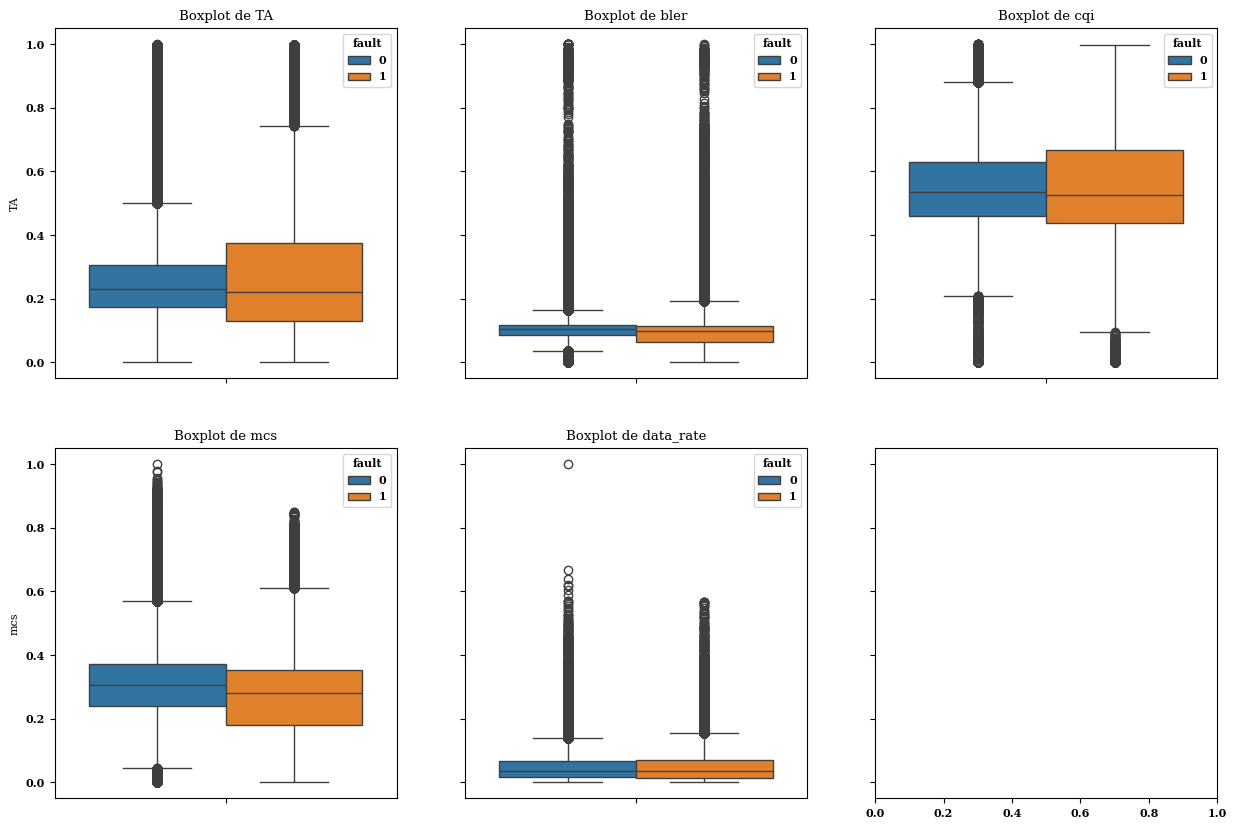

In [ ]:
boxplots(df_labeled_res)

## **INDIVIDUAL MODELS**

### imports

In [8]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
import time

/home/usr/anaconda3/envs/cnn-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### help functions

In [9]:
def fitness_func(acc, rec):
    return (acc * rec) * rec


In [10]:
def execute(model, data):
  start = time.time()
  pred = model.predict(data)
  end = time.time()
  t = end - start
  inf_t = t/len(data)

  print("time elapsed: " + "{:.4f}".format(t) + " seconds")
  print("mean inference time: "+ str(inf_t) + " seconds")
  return pred

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, f1_score, recall_score

def show_results(y_test, predictions):
  print('Accuracy score:', accuracy_score(y_test, predictions))
  print('f1 score:', f1_score(y_test, predictions))
  print('recall score:', recall_score(y_test, predictions))

  font = {'family' : 'serif', 'weight' : 'bold', 'size':18}
  plt.rc('font', **font)
  disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions), display_labels=None)
  disp.plot()
  plt.show()

### XGBoost Model

In [12]:
import xgboost as xgb
import time

time elapsed: 2.2673 seconds
mean inference time: 1.3438738052874014e-05 seconds
Accuracy score: 0.9642109880209352
f1 score: 0.6973433583959899
recall score: 0.9383515445838392


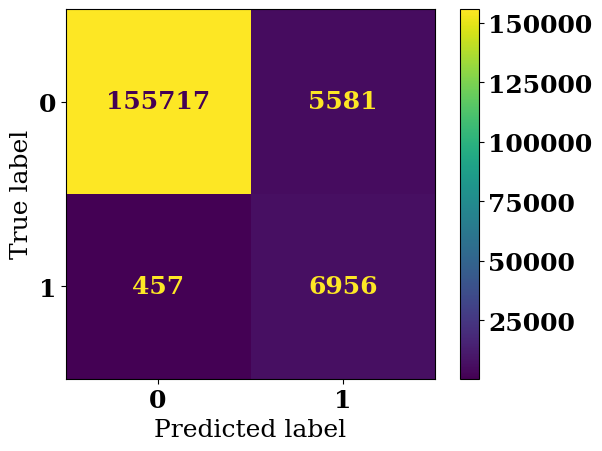

In [13]:
params= {'n_estimators': 1699,
 'learning_rate': 0.15056893686359246,
 'max_depth': 9,
 'subsample': 0.7440714124829109,
 'min_child_weight': 4}

xgb_classifier = xgb.XGBClassifier(**params)
xgb_classifier = xgb_classifier.fit(X_train_smoteen, y_train_smoteen)

xgb_pred = execute(xgb_classifier, X_test_smoteen)
show_results(y_test_smoteen, xgb_pred)

In [14]:
import joblib
joblib.dump(xgb_classifier ,"/home/usr/Documents/oversample-benchmark/models/xgb_best.pkl")

['/home/usr/Documents/oversample-benchmark/models/xgb_best.pkl']

#### optimization

In [47]:
def objectiveXGB(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1, 2000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_smoteen, y_train_smoteen)

    y_pred = model.predict(X_test_smoteen)
    acc = accuracy_score(y_test_smoteen, y_pred )
    rec = recall_score(y_test_smoteen, y_pred )

    return fitness_func(acc, rec)

In [48]:
sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objectiveXGB, n_trials=20)

[I 2024-06-20 11:31:41,138] A new study created in memory with name: no-name-74777591-5d22-43c9-87db-c1a492850748
[I 2024-06-20 11:32:40,666] Trial 0 finished with value: 0.2830112382615402 and parameters: {'n_estimators': 1393, 'learning_rate': 0.005114484048333241, 'max_depth': 3, 'subsample': 0.5737490306287467, 'min_child_weight': 15}. Best is trial 0 with value: 0.2830112382615402.
[I 2024-06-20 11:33:25,551] Trial 1 finished with value: 0.7860929650819157 and parameters: {'n_estimators': 847, 'learning_rate': 0.2688263538705781, 'max_depth': 7, 'subsample': 0.5068853064101428, 'min_child_weight': 8}. Best is trial 1 with value: 0.7860929650819157.
[I 2024-06-20 11:33:51,125] Trial 2 finished with value: 0.4804787556054126 and parameters: {'n_estimators': 687, 'learning_rate': 0.06396531249290083, 'max_depth': 5, 'subsample': 0.10669400177908993, 'min_child_weight': 8}. Best is trial 1 with value: 0.7860929650819157.
[I 2024-06-20 11:34:21,746] Trial 3 finished with value: 0.24139

In [46]:
from joblib import load, dump
%cd '/home/usr/Documents/reg-class-fault-detection/dataset/models'
dump(xgb_classifier, 'xgb_075split_non-opt.joblib')

/home/usr/Documents/reg-class-fault-detection/dataset/models


/home/usr/anaconda3/envs/cnn-env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning:

using dhist requires you to install the `pickleshare` library.



['xgb_075split_non-opt.joblib']

### KNN

Relações entre tamanho da amostra e num de vizinhos:

S- 0.25 ; N- 2

time elapsed: 23.7408 seconds
mean inference time: 0.0005628727674992994 seconds
Accuracy score: 0.8694580112855043
f1 score: 0.38204264870931537
recall score: 0.9331140350877193


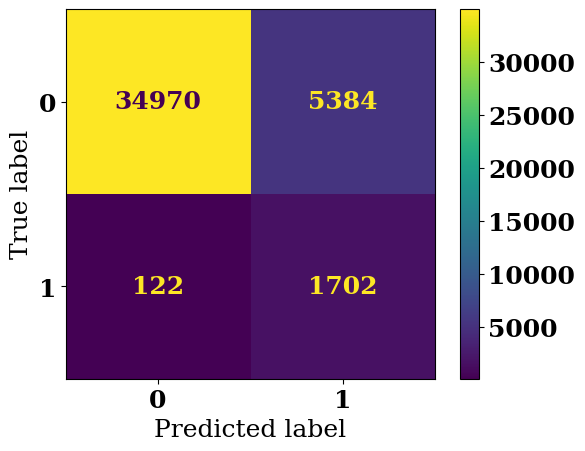

In [23]:
knearest = KNeighborsClassifier(n_neighbors = 2)
knearest = knearest.fit(X_train_smoteen, y_train_smoteen)
knn_pred = execute(knearest, X_test_smoteen)
show_results(y_test_smoteen, knn_pred)

In [34]:
from joblib import load, dump

%cd '/home/usr/Documents/reg-class-fault-detection/dataset/models'
dump(knearest, 'knn_025split_n=2.joblib')

/home/usr/anaconda3/envs/cnn-env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning:

using dhist requires you to install the `pickleshare` library.



/home/usr/Documents/reg-class-fault-detection/dataset/models


['knn_025split_n=2.joblib']

### CATBOOST

In [ ]:
%cd '/home/usr/Documents/reg-class-fault-detection/dataset/catboost'
from catboost import CatBoostClassifier
from catboost import Pool
from catboost.utils import eval_metric

/home/usr/Documents/reg-class-fault-detection/dataset/catboost


/home/usr/anaconda3/envs/cnn-env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


0:	learn: 0.6712208	total: 835ms	remaining: 13m 54s
100:	learn: 0.4872197	total: 1m 16s	remaining: 11m 21s
200:	learn: 0.4199921	total: 2m 31s	remaining: 10m 1s
300:	learn: 0.3796601	total: 3m 46s	remaining: 8m 46s
400:	learn: 0.3475678	total: 5m 2s	remaining: 7m 31s
500:	learn: 0.3284811	total: 6m 17s	remaining: 6m 15s
600:	learn: 0.3140528	total: 7m 32s	remaining: 5m
700:	learn: 0.3056895	total: 8m 46s	remaining: 3m 44s
800:	learn: 0.2974712	total: 10m	remaining: 2m 29s
900:	learn: 0.2919180	total: 11m 15s	remaining: 1m 14s
999:	learn: 0.2875290	total: 12m 29s	remaining: 0us
time elapsed: 0.0941 seconds
mean inference time: 1.29246329255267e-06 seconds
Accuracy score: 0.8241814086364135
f1 score: 0.27559277912964747
recall score: 0.8176628609805239


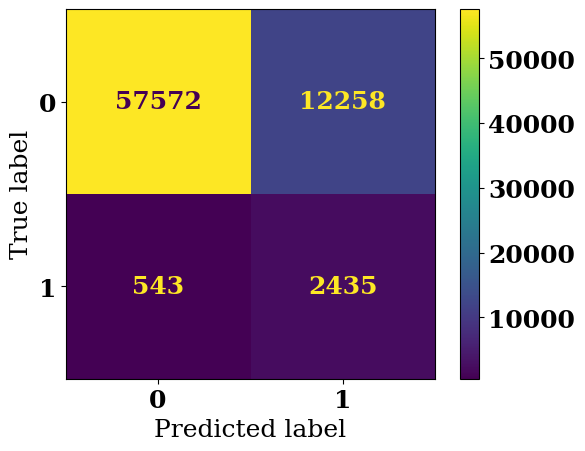

In [ ]:
params = {'verbose': 100, 'learning_rate': 0.09039022742364758, 'depth': 10, 'l2_leaf_reg': 7.1634676472637695, 'boosting_type': 'Ordered'}
params_2 = {'learning_rate': 0.07136219363210386, 'depth': 5, 'l2_leaf_reg': 3.0543690779106005, 'boosting_type': 'Plain'}

cat = CatBoostClassifier(**params_2)

CatBoostClassifier()
cat.fit(
    X_train_res_2, y_train_res_2,
)

cat_pred = execute(cat, X_test_res)
show_results(y_test_res, cat_pred)


#### hyperparameter optimization

In [ ]:

def objective(trial):

    train_pool = Pool(X_train_res_2, y_train_res_2)
    test_pool = Pool(X_test_res, y_test_res)

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
    }

    model = CatBoostClassifier(**params, random_seed=42)
    model.fit(train_pool, verbose=0, eval_set=test_pool)
    y_pred = model.predict(X_test_res)
    acc = accuracy_score(y_test_res, y_pred )
    rec = recall_score(y_test_res, y_pred )

    return fitness_func(acc, rec)

sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# params = {'n_estimators': 94, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 1}
# acc: 0.933 rec:0.882

# params={'n_estimators': 49, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 4}
# acc: 0.918 rec:0.873

time elapsed: 0.5075 seconds
mean inference time: 1.203297065113702e-05 seconds
Accuracy score: 0.9184408933567263
f1 score: 0.4808330817989737
recall score: 0.8733552631578947


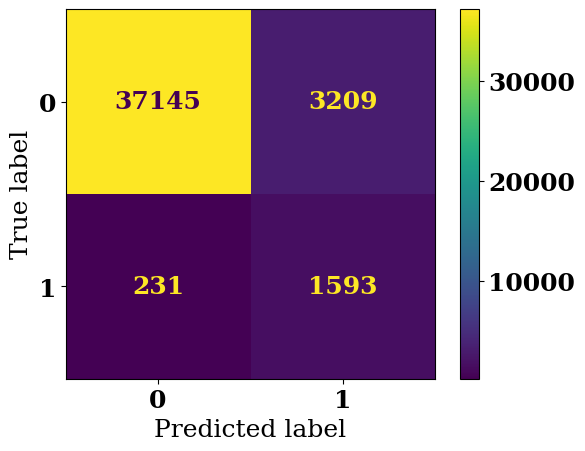

In [32]:

rf = RandomForestClassifier(**params)
rf = rf.fit(X_train_smoteen, y_train_smoteen)
rf_pred = execute(rf, X_test_smoteen)
show_results(y_test_smoteen, rf_pred)

In [39]:
%cd '/home/usr/Documents/reg-class-fault-detection/dataset/models'
dump(rf, 'rf_025split_opt.joblib')

/home/usr/Documents/reg-class-fault-detection/dataset/models


/home/usr/anaconda3/envs/cnn-env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning:

using dhist requires you to install the `pickleshare` library.



['rf_025split_opt.joblib']

In [38]:
import plotly.express as px
fig = px.bar(x=test_smoteen_df.drop(columns = ['fault']).columns , y=rf.feature_importances_)
fig.show()

#### optimization

In [28]:
def objectiveRF(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 200, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Create and fit random forest model
    model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42,
    )
    model.fit(X_train_smoteen, y_train_smoteen)

    y_pred = model.predict(X_test_smoteen)
    acc = accuracy_score(y_test_smoteen, y_pred )
    rec = recall_score(y_test_smoteen, y_pred )

    return fitness_func(acc, rec)

In [29]:
# Create study object
study = optuna.create_study(direction="maximize")
study.optimize(objectiveRF, n_trials=20, show_progress_bar=True)

[I 2024-06-20 09:38:07,065] A new study created in memory with name: no-name-d3328718-31e8-4562-b67c-a98b362ce2b8
Best trial: 0. Best value: 0.681558:   5%|▌         | 1/20 [05:27<1:43:35, 327.11s/it]

[I 2024-06-20 09:43:34,176] Trial 0 finished with value: 0.6815580340717988 and parameters: {'n_estimators': 157, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6815580340717988.


Best trial: 0. Best value: 0.681558:  10%|█         | 2/20 [11:01<1:39:29, 331.61s/it]

[I 2024-06-20 09:49:08,942] Trial 1 finished with value: 0.6694736742861502 and parameters: {'n_estimators': 160, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6815580340717988.


Best trial: 2. Best value: 0.722155:  15%|█▌        | 3/20 [13:54<1:13:21, 258.94s/it]

[I 2024-06-20 09:52:01,392] Trial 2 finished with value: 0.7221552045702229 and parameters: {'n_estimators': 78, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.7221552045702229.


Best trial: 2. Best value: 0.722155:  20%|██        | 4/20 [16:49<1:00:16, 226.05s/it]

[I 2024-06-20 09:54:57,024] Trial 3 finished with value: 0.29524280009408743 and parameters: {'n_estimators': 186, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.7221552045702229.


Best trial: 2. Best value: 0.722155:  25%|██▌       | 5/20 [18:40<46:08, 184.54s/it]  

[I 2024-06-20 09:56:47,970] Trial 4 finished with value: 0.6668088880844307 and parameters: {'n_estimators': 51, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.7221552045702229.


Best trial: 2. Best value: 0.722155:  30%|███       | 6/20 [18:58<29:50, 127.91s/it]

[I 2024-06-20 09:57:05,950] Trial 5 finished with value: 0.29002787487247356 and parameters: {'n_estimators': 20, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.7221552045702229.


Best trial: 2. Best value: 0.722155:  35%|███▌      | 7/20 [21:03<27:30, 126.95s/it]

[I 2024-06-20 09:59:10,936] Trial 6 finished with value: 0.6451101140360437 and parameters: {'n_estimators': 60, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.7221552045702229.


Best trial: 2. Best value: 0.722155:  40%|████      | 8/20 [21:10<17:44, 88.72s/it] 

[I 2024-06-20 09:59:17,805] Trial 7 finished with value: 0.20479167858982855 and parameters: {'n_estimators': 24, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.7221552045702229.


Best trial: 2. Best value: 0.722155:  45%|████▌     | 9/20 [22:57<17:18, 94.38s/it]

[I 2024-06-20 10:01:04,629] Trial 8 finished with value: 0.6788257762297525 and parameters: {'n_estimators': 52, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7221552045702229.


Best trial: 2. Best value: 0.722155:  50%|█████     | 10/20 [23:29<12:30, 75.05s/it]

[I 2024-06-20 10:01:36,387] Trial 9 finished with value: 0.6381199666652065 and parameters: {'n_estimators': 15, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.7221552045702229.


Best trial: 2. Best value: 0.722155:  55%|█████▌    | 11/20 [25:57<14:37, 97.50s/it]

[I 2024-06-20 10:04:04,787] Trial 10 finished with value: 0.5388803808001539 and parameters: {'n_estimators': 86, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.7221552045702229.


Best trial: 11. Best value: 0.723966:  60%|██████    | 12/20 [30:05<19:05, 143.24s/it]

[I 2024-06-20 10:08:12,661] Trial 11 finished with value: 0.723966204685374 and parameters: {'n_estimators': 109, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 11 with value: 0.723966204685374.


Best trial: 12. Best value: 0.734758:  65%|██████▌   | 13/20 [33:38<19:10, 164.40s/it]

[I 2024-06-20 10:11:45,746] Trial 12 finished with value: 0.734757805051416 and parameters: {'n_estimators': 94, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 12 with value: 0.734757805051416.


Best trial: 12. Best value: 0.734758:  70%|███████   | 14/20 [37:40<18:46, 187.83s/it]

[I 2024-06-20 10:15:47,721] Trial 13 finished with value: 0.7242809373276504 and parameters: {'n_estimators': 107, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 12 with value: 0.734757805051416.


Best trial: 12. Best value: 0.734758:  75%|███████▌  | 15/20 [38:49<12:40, 152.01s/it]

[I 2024-06-20 10:16:56,706] Trial 14 finished with value: 0.6118945712231498 and parameters: {'n_estimators': 35, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 12 with value: 0.734757805051416.


Best trial: 12. Best value: 0.734758:  80%|████████  | 16/20 [42:08<11:04, 166.05s/it]

[I 2024-06-20 10:20:15,362] Trial 15 finished with value: 0.5599268122323072 and parameters: {'n_estimators': 109, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 12 with value: 0.734757805051416.


Best trial: 12. Best value: 0.734758:  85%|████████▌ | 17/20 [42:31<06:09, 123.11s/it]

[I 2024-06-20 10:20:38,629] Trial 16 finished with value: 0.6701462324882286 and parameters: {'n_estimators': 10, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 12 with value: 0.734757805051416.


Best trial: 12. Best value: 0.734758:  90%|█████████ | 18/20 [46:12<05:05, 152.60s/it]

[I 2024-06-20 10:24:19,857] Trial 17 finished with value: 0.6687646165442249 and parameters: {'n_estimators': 110, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 12 with value: 0.734757805051416.


Best trial: 12. Best value: 0.734758:  95%|█████████▌| 19/20 [47:36<02:11, 131.84s/it]

[I 2024-06-20 10:25:43,336] Trial 18 finished with value: 0.6942196154086752 and parameters: {'n_estimators': 36, 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 12 with value: 0.734757805051416.


Best trial: 12. Best value: 0.734758: 100%|██████████| 20/20 [49:28<00:00, 148.44s/it]

[I 2024-06-20 10:27:35,901] Trial 19 finished with value: 0.4533367694991935 and parameters: {'n_estimators': 75, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 12 with value: 0.734757805051416.


In [30]:
# Import optuna.visualization
import optuna.visualization as vis
print("Best trial:", study.best_trial)
vis.plot_optimization_history(study)

Best trial: FrozenTrial(number=12, state=1, values=[0.734757805051416], datetime_start=datetime.datetime(2024, 6, 20, 10, 8, 12, 665940), datetime_complete=datetime.datetime(2024, 6, 20, 10, 11, 45, 746395), params={'n_estimators': 94, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=200, log=True, low=10, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=12, value=None)


In [ ]:
optuna.visualization.plot_param_importances(study)

## PCA

<Axes: xlabel='x', ylabel='y'>

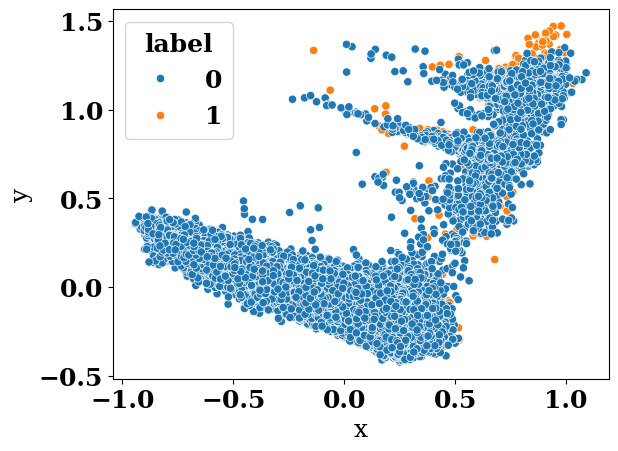

In [ ]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

target_names = ['no fault', 'fault']

pca = PCA(n_components=2)
X_r = pca.fit(X_test_res).transform(X_test_res)

pca_df = pd.DataFrame()
pca_df[['x', 'y']] = X_r
pca_df['label'] = y_test_res

sn.scatterplot(data=pca_df, x="x", y="y", hue="label")

## SHAP: Voting Classifier

#### imports and downloads

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import shap
shap.initjs()

#### special data treatment for shap

In [90]:
# df_shap_train = df_train_res.drop(columns=['fault']).copy()
# df_shap_train[df_shap_train.columns] = X_train_res

# df_shap_test = test_split_df.drop(columns=['fault_duration','fault','bin'])
# df_shap_test[df_shap_test.columns] = X_test_res

df_shap_train = train_smoteen_df.drop(columns=['fault'])
df_shap_test = test_smoteen_df.drop(columns=['fault'])

In [92]:
def f(x):
    return xgb_classifier.predict_proba(x)[:, 1]

In [93]:
med = df_shap_train.median().values.reshape((1, df_shap_train.shape[1]))
explainer = shap.Explainer(f, med)

In [94]:
shap_values = explainer(df_shap_test.iloc[0:2000, :])

PermutationExplainer explainer: 2001it [06:33,  4.94it/s]                          


In [95]:
shap_v = shap.TreeExplainer(xgb_classifier).shap_values(df_shap_test[:2000].values)

#### shap results

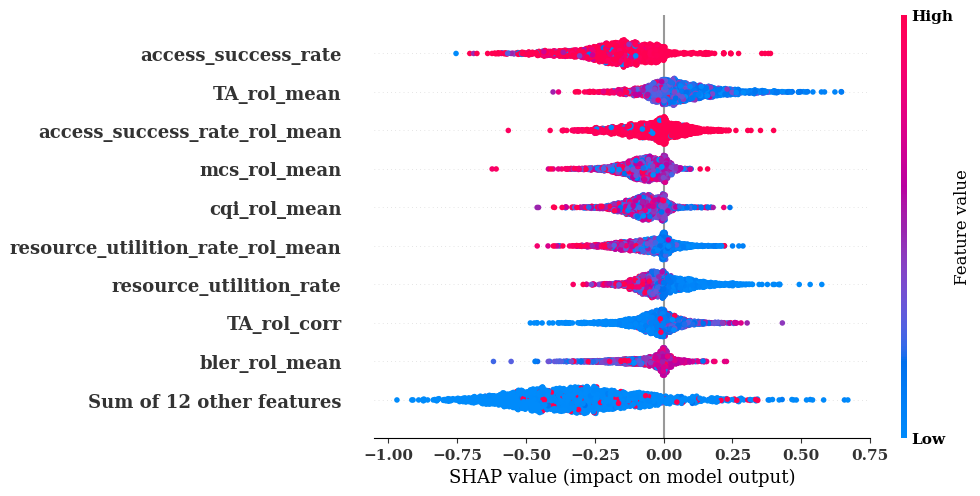

In [96]:
shap.plots.beeswarm(shap_values)

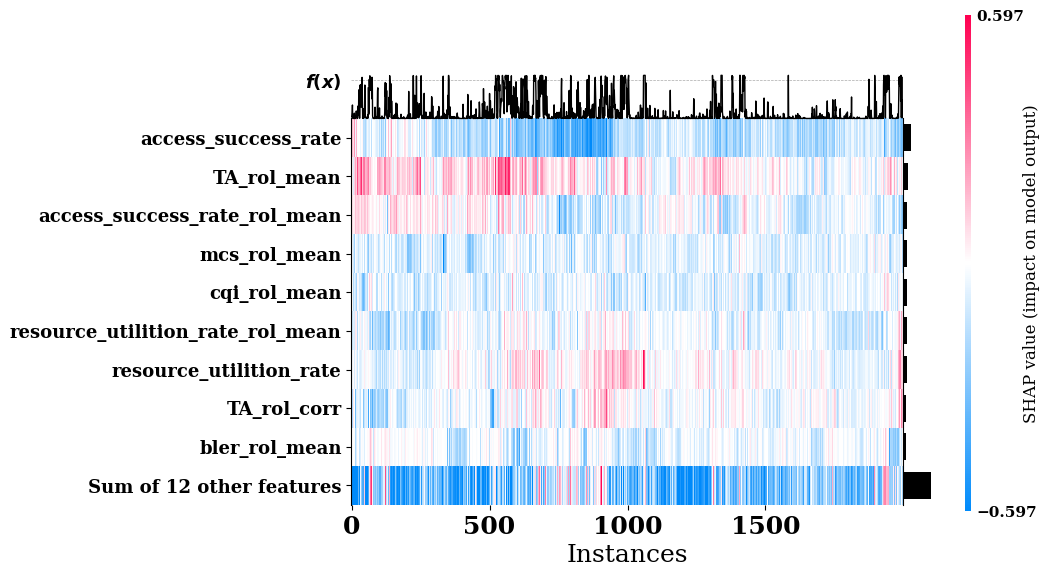

In [97]:
shap.plots.heatmap(shap_values)

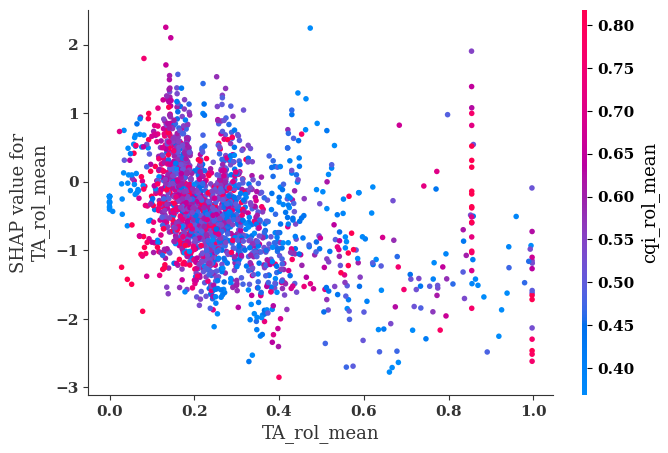

In [98]:
shap.dependence_plot("TA_rol_mean", shap_v, df_shap_test.iloc[0:2000, :])

In [99]:
shap_interaction_values = shap.TreeExplainer(xgb_classifier).shap_interaction_values(
    df_shap_test.iloc[:2000, :]
)
shap.summary_plot(shap_interaction_values, df_shap_test.iloc[:2000, :])